In [1]:
import os
import umap
import h5py
import torch
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from torch import nn
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

/u/sauves/TP6/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# custom 
import common.engines as engines 
import common.plotting as plotting 
import common.dataprocessing as dataprocessing


# Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers.
### Important: prière d'exécuter les cellules dans l'ordre ou redémarrer le noyau :) 
## 0. Introduction à git et préparation des données.


In [3]:
datasets = dataprocessing.load_datasets()

In [4]:
datasetname = "LAML"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].genes
labels = datasets[datasetname].labels
samples = datasets[datasetname].samples

## I. Visualisation avec UMAP

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)

In [6]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Thu Dec  7 00:16:51 2023 Construct fuzzy simplicial set
Thu Dec  7 00:16:51 2023 Finding Nearest Neighbors
Thu Dec  7 00:16:53 2023 Finished Nearest Neighbor Search
Thu Dec  7 00:16:55 2023 Construct embedding


Epochs completed:  67%| ██████▋    669/1000 [00:01]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs


Epochs completed: 100%| ██████████ 1000/1000 [00:01]


	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec  7 00:16:57 2023 Finished embedding


In [7]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   2%| ▏          6/333 [00:01]

	completed  0  /  333 epochs


Epochs completed: 100%| ██████████ 333/333 [00:01]

	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


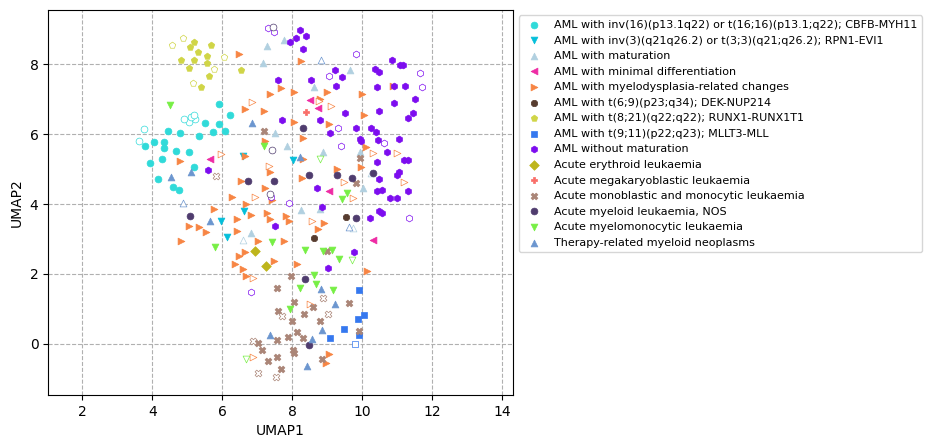

In [8]:
plotting.plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s = 24)

## II. Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur. 
### II.1 Créez une fonction qui construit un modèle DNN selon la structure <code>encoder => bottleneck => decoder</code>


In [9]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [10]:
mm,encoder  = engines.auto_encoder(insize, insize, 2)
encoder(X_train).shape
mm.parameters()

<generator object Module.parameters at 0x7fcc1435db60>

### II.2 Lancez un entrainement de 1000 epochs et enregistrez la performance du modèle par epoch sous la forme de l'erreur et la correlation de Pearson sur l'ensemble de test et de train.

In [11]:
mm, trl, tstl, trc, tstc  = engines.train_auto_encoder(insize, 2, X_train, X_test, nepochs = 300, lr = 5 * 1e-4)


Loss 0 Train - loss : 1.209 - acc : -0.004 Test acc : -0.004
Loss 10 Train - loss : 1.144 - acc : 0.121 Test acc : 0.12
Loss 20 Train - loss : 1.051 - acc : 0.234 Test acc : 0.233
Loss 30 Train - loss : 0.736 - acc : 0.433 Test acc : 0.431
Loss 40 Train - loss : 0.301 - acc : 0.734 Test acc : 0.732
Loss 50 Train - loss : 0.114 - acc : 0.9 Test acc : 0.897
Loss 60 Train - loss : 0.066 - acc : 0.941 Test acc : 0.939
Loss 70 Train - loss : 0.053 - acc : 0.953 Test acc : 0.95
Loss 80 Train - loss : 0.048 - acc : 0.957 Test acc : 0.954
Loss 90 Train - loss : 0.046 - acc : 0.959 Test acc : 0.956
Loss 100 Train - loss : 0.045 - acc : 0.959 Test acc : 0.957
Loss 110 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957
Loss 120 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957
Loss 130 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957
Loss 140 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957
Loss 150 Train - loss : 0.044 - acc : 0.96 Test acc : 0.958
Loss 160 Train - loss : 0.044 - acc : 0.96

### II.3 Produisez la courbe d'apprentissage de l'entrainement de ce réseau, c'est à dire la courbe de l'erreur sur le test et le train et la corrélation de Pearson selon les epochs. 

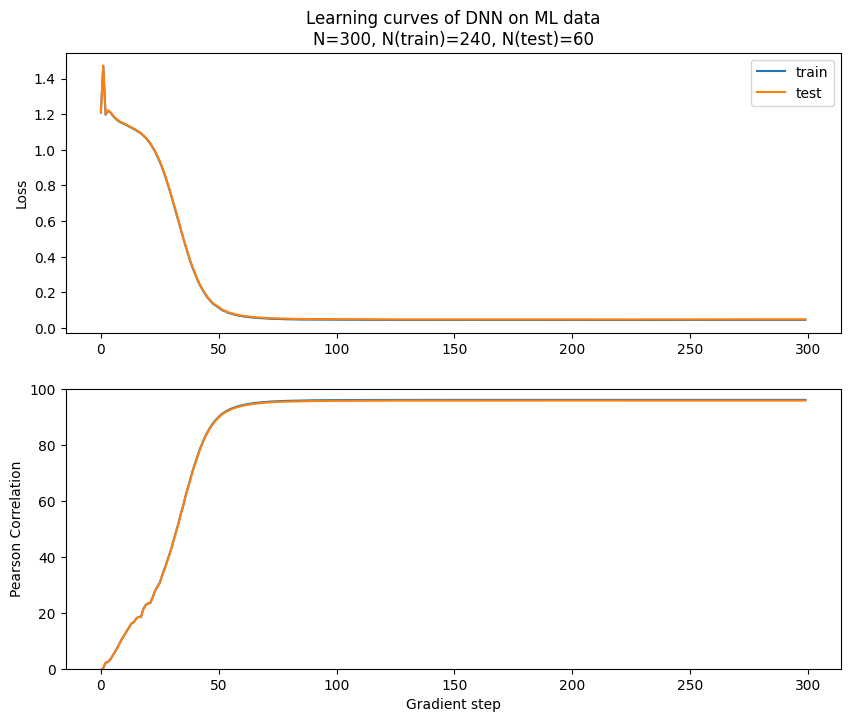

In [12]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)

### II.4 Faites la visualisation de la corrélation sur les données de test prédites et vraies. <u>Rapportez votre résultat sous la forme d'un histogramme 2D avec des hexagones, l'échelle de la densité doit être rapportées.

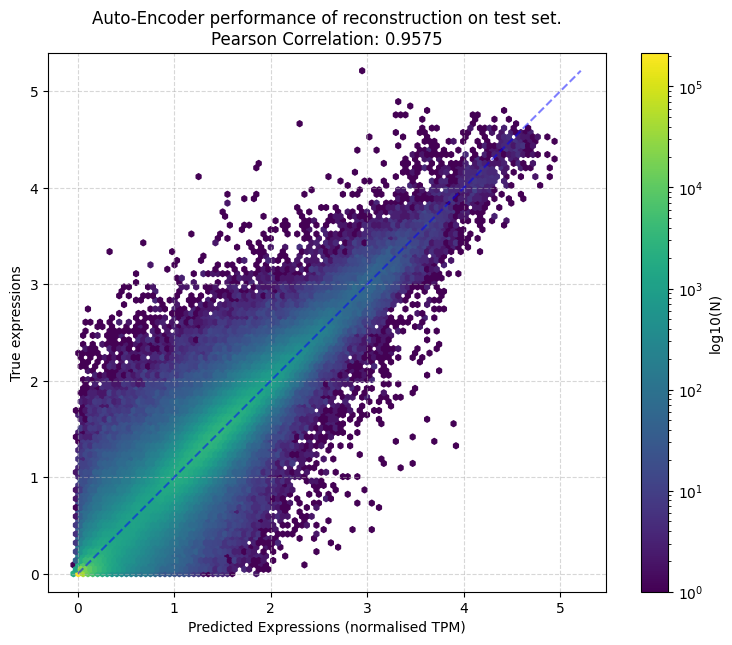

In [13]:
plotting.plot_ae_performance(mm, X_test, dataset = datasetname)
    

## III. Variational Auto-Encoders (VAE) pour un gain de performance de reconstruction dans les problèmes de régression. (seance 2)

In [14]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [15]:
mm = engines.VariationalAutoencoder(insize, 2)

In [16]:
mm(X_train)

tensor([[ 0.1590,  0.2443,  0.2878,  ...,  0.1138, -0.1212,  0.1562],
        [ 0.1559,  0.1336,  0.5531,  ...,  0.0058, -0.3676,  0.0009],
        [ 0.1637, -0.0206,  0.7590,  ...,  0.1008, -0.9227, -0.1059],
        ...,
        [ 0.0986,  0.2300,  0.0915,  ...,  0.1779, -0.0064,  0.2455],
        [ 0.1297,  0.2479,  0.3256,  ...,  0.1302, -0.1964,  0.0408],
        [-0.0145,  0.1870,  0.3661,  ...,  0.1790, -0.3491,  0.0142]],
       grad_fn=<AddmmBackward0>)

In [17]:
VAE, trl, tstl, trc, tstc = engines.train_variational_auto_encoder(insize, 125, X_train, X_test, nepochs = 300, printstep = 10, wd = 1e-3, lr = 0.0001)

Loss 0 Train - loss : 1.293 - acc : -0.004 Test acc : -0.003
Loss 10 Train - loss : 1.199 - acc : 0.025 Test acc : 0.026
Loss 20 Train - loss : 1.183 - acc : 0.053 Test acc : 0.053
Loss 30 Train - loss : 1.167 - acc : 0.082 Test acc : 0.083
Loss 40 Train - loss : 1.15 - acc : 0.112 Test acc : 0.112
Loss 50 Train - loss : 1.134 - acc : 0.141 Test acc : 0.141
Loss 60 Train - loss : 1.115 - acc : 0.164 Test acc : 0.165
Loss 70 Train - loss : 1.088 - acc : 0.189 Test acc : 0.19
Loss 80 Train - loss : 1.049 - acc : 0.224 Test acc : 0.224
Loss 90 Train - loss : 0.989 - acc : 0.264 Test acc : 0.265
Loss 100 Train - loss : 0.895 - acc : 0.326 Test acc : 0.326
Loss 110 Train - loss : 0.767 - acc : 0.408 Test acc : 0.408
Loss 120 Train - loss : 0.622 - acc : 0.503 Test acc : 0.503
Loss 130 Train - loss : 0.479 - acc : 0.602 Test acc : 0.602
Loss 140 Train - loss : 0.354 - acc : 0.695 Test acc : 0.695
Loss 150 Train - loss : 0.257 - acc : 0.774 Test acc : 0.774
Loss 160 Train - loss : 0.188 - acc

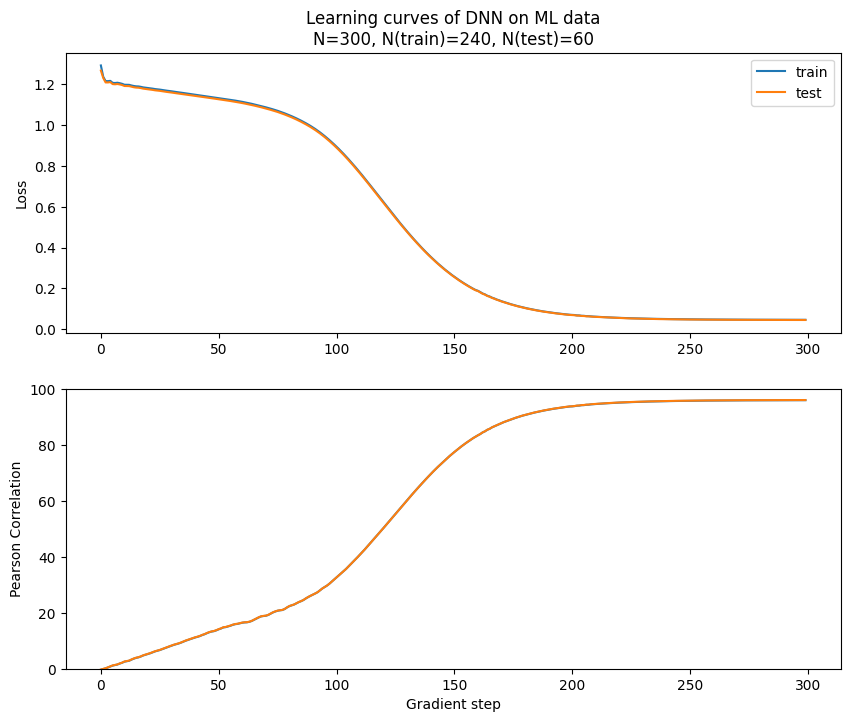

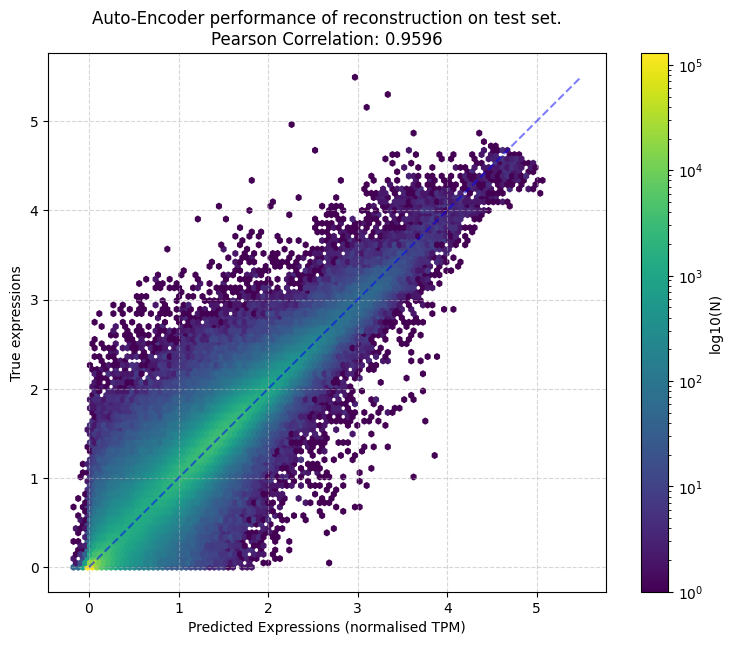

In [18]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)
plotting.plot_ae_performance(VAE, X_test, modeltype ="VAE", dataset = datasetname)

## IV. UMAP supervise

In [20]:
lblenc = LabelEncoder()
lblenc.fit(labels)
Y = lblenc.transform(labels)
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, Y, test_size = 0.2)
mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =10, n_epochs = 1000).fit(X_train,  y = Y_train)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=10, verbose=1)
Thu Dec  7 00:19:32 2023 Construct fuzzy simplicial set
Thu Dec  7 00:19:32 2023 Finding Nearest Neighbors
Thu Dec  7 00:19:32 2023 Finished Nearest Neighbor Search
Thu Dec  7 00:19:32 2023 Construct embedding


Epochs completed:  78%| ███████▊   778/1000 [00:01]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs


Epochs completed: 100%| ██████████ 1000/1000 [00:01]


	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec  7 00:19:34 2023 Finished embedding


In [21]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed: 100%| ██████████ 333/333 [00:01]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


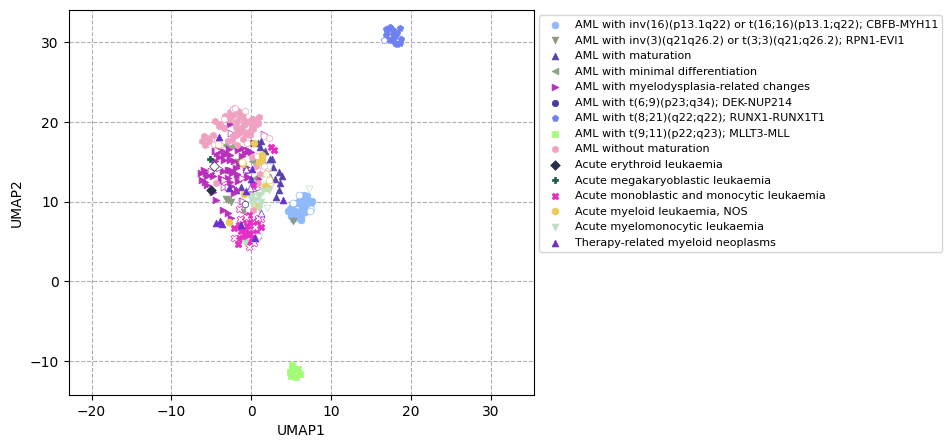

In [24]:
plotting.plot_umap(X_tr_umap, X_tst_umap, lblenc.inverse_transform(Y_train), lblenc.inverse_transform(Y_test), labels, s = 24)

## Projets : 
### Projet 5 C: Auto-Encodeur Lineaire vs PCA 

In [48]:
datasetname = "LAML"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].genes
labels = datasets[datasetname].labels
samples = datasets[datasetname].samples

In [49]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(tpm_data.T), Y, test_size = 0.2)
insize = X_train.shape[1]

In [62]:
### fonction d'initialisation du reseau
def linear_auto_encoder(insize, outsize, bnsize, width=500):
    model = nn.Sequential(
    nn.Linear(insize,width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, bnsize, bias = False), 
    nn.Linear(bnsize, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, outsize, bias = False))
    return model, model[0:3]


def train_linear_auto_encoder(insize, bnsize, X_train, X_test, nepochs = 100, printstep=10, wd = 1e-3, lr = 0.0001):
    DNN, encoder = linear_auto_encoder(insize, insize, bnsize )
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.mse_loss(y_tr_out, X_train) # loss computation
        tst_loss = nn.functional.mse_loss(y_tst_out, X_test) # Softmax -> NLL
        
        tr_acc = pearsonr(y_tr_out.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic # Pearson corr. coeff
        tst_acc = pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),3)} - acc : {round(float(tr_acc),3)} Test acc : {round(tst_acc,3)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)


In [63]:
LAE, trl, tstl, trc, tstc = train_linear_auto_encoder(insize, 2, X_train, X_test, nepochs = 100, lr = 1e-4)

Loss 0 Train - loss : 1.187 - acc : -0.002 Test acc : -0.001
Loss 10 Train - loss : 1.141 - acc : 0.116 Test acc : 0.116
Loss 20 Train - loss : 0.666 - acc : 0.434 Test acc : 0.431
Loss 30 Train - loss : 0.263 - acc : 0.77 Test acc : 0.767
Loss 40 Train - loss : 0.107 - acc : 0.906 Test acc : 0.903
Loss 50 Train - loss : 0.064 - acc : 0.942 Test acc : 0.939
Loss 60 Train - loss : 0.051 - acc : 0.954 Test acc : 0.952
Loss 70 Train - loss : 0.047 - acc : 0.958 Test acc : 0.956
Loss 80 Train - loss : 0.045 - acc : 0.959 Test acc : 0.957
Loss 90 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957
Loss 99 Train - loss : 0.045 - acc : 0.96 Test acc : 0.957


In [64]:
LAE_X_train = LAE[0:3](X_train).detach().numpy()
LAE_X_test = LAE[0:3](X_test).detach().numpy()

In [65]:
pca = PCA(n_components=2)
pca.fit(X_train)
PCA_X_train = pca.transform(X_train)
PCA_X_test = pca.transform(X_test)

In [66]:
y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())
y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

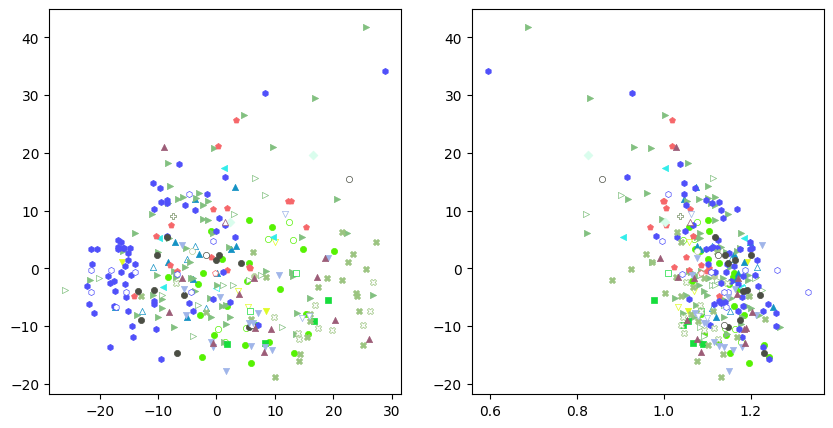

In [67]:
def random_color_generator():
    r = random.randint(0, 255)/256
    g = random.randint(0, 255)/256
    b = random.randint(0, 255)/256
    return (r, g, b)
# comparison 
fig, axes = plt.subplots(ncols = 2, figsize = (10,5))
s = 20
markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
colors_by_ctype = [random_color_generator() for  i in range(len(np.unique(labels)))]
for (i,lbl) in enumerate(np.unique(labels)):
    axes[0].scatter(PCA_X_train[y_tr_labs ==lbl,0], 
                PCA_X_train[y_tr_labs ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
    axes[0].scatter(PCA_X_test[ y_tst_labs ==lbl,0], 
            PCA_X_test[y_tst_labs==lbl,1], 
            s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])
    axes[1].scatter(LAE_X_train[y_tr_labs ==lbl,0], 
                PCA_X_train[y_tr_labs ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
    axes[1].scatter(LAE_X_test[ y_tst_labs ==lbl,0], 
            PCA_X_test[y_tst_labs==lbl,1], 
            s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])

## Projet: comparaison de methodes 